<a href="https://colab.research.google.com/github/letiziamolinari/TMSA-PROJECT/blob/main/SARCASM_ON_REDDIT_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"letiziamolinari","key":"54796e38d700f0623a18599505a2409f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d danofer/sarcasm

 98% 211M/216M [00:03<00:00, 38.3MB/s]
100% 216M/216M [00:03<00:00, 61.5MB/s]


In [ ]:
ls

'kaggle (1).json'   sample_data/          train-balanced-sarcasm.csv
'kaggle (2).json'   sarcasm.zip           train-balanced-sarc.csv.gz
'kaggle (3).json'   test-balanced.csv
 kaggle.json        test-unbalanced.csv


In [ ]:
! unzip sarcasm.zip && rm sarcasm.zip

Archive:  sarcasm.zip
replace test-balanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test-balanced.csv       
replace test-unbalanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test-unbalanced.csv     
replace train-balanced-sarc.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-balanced-sarc.csv.gz  
replace train-balanced-sarcasm.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-balanced-sarcasm.csv  


In [ ]:
import pandas as pd 
pd.set_option('display.max_colwidth', None)
import os
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from matplotlib import pyplot as plt
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

In [ ]:
#loading of the data
df = pd.read_csv("train-balanced-sarcasm.csv")
df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT
5,0,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat story?
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his greatness with *my* weak builds. He should equip *ONLY* the best TMs.
8,0,"You don't have to, you have a good build, buy games or save it",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,"What to upgrade? I have $500 to spend (mainly because it's my birthday on the 31st) and I'm not really sure what to upgrade. I don't have to spend all $500, I could spend as little or all of it if I want. Specs are: CPU: i5-6600K Cooler: CM 212 EVO RAM: 8GB Corsair Vengence LPX 2400MHz GPU: EVGA GTX 1070 SC Case: Corsair Spec Alpha PSU: EVGA P2 650w Storage: One 480 GB Corsair Force LE Monitor: BenQ XL2411Z Keyboard: Razer Blackwidow Tournament Edition What I'm thinking of right now is: -Get a 1TB WD Blue -Buy another 8GB of RAM -Replace my Razer Blackwidow with a keyboard with actual Cherry MX switches -Replace my case (Doesn't really offer features for good cable management) -Save up for a Volta Card"
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,"Probably count Kanye out Since the rest of his tour is canceled, it doesn't seem in the cards. But he's also so unpredictable, it could change. Thankfully I saw him before he started canceling shows, going on long rants and showing up late. But I'd love to see him again, especially at Lolla. Thoughts?"


In [ ]:
#consider only columns "label","subreddit","parent_comment"
df = df[["label","subreddit","parent_comment"]]
df.head(10)

,label,subreddit,parent_comment
0,0,politics,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,nba,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,nfl,They're favored to win.
3,0,BlackPeopleTwitter,deadass don't kill my buzz
4,0,MaddenUltimateTeam,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT
5,0,AskReddit,do you find ariana grande sexy ?
6,0,AskReddit,What's your weird or unsettling Trick or Treat story?
7,0,FFBraveExvius,Probably Sephiroth. I refuse to taint his greatness with *my* weak builds. He should equip *ONLY* the best TMs.
8,0,pcmasterrace,"What to upgrade? I have $500 to spend (mainly because it's my birthday on the 31st) and I'm not really sure what to upgrade. I don't have to spend all $500, I could spend as little or all of it if I want. Specs are: CPU: i5-6600K Cooler: CM 212 EVO RAM: 8GB Corsair Vengence LPX 2400MHz GPU: EVGA GTX 1070 SC Case: Corsair Spec Alpha PSU: EVGA P2 650w Storage: One 480 GB Corsair Force LE Monitor: BenQ XL2411Z Keyboard: Razer Blackwidow Tournament Edition What I'm thinking of right now is: -Get a 1TB WD Blue -Buy another 8GB of RAM -Replace my Razer Blackwidow with a keyboard with actual Cherry MX switches -Replace my case (Doesn't really offer features for good cable management) -Save up for a Volta Card"
9,0,Lollapalooza,"Probably count Kanye out Since the rest of his tour is canceled, it doesn't seem in the cards. But he's also so unpredictable, it could change. Thankfully I saw him before he started canceling shows, going on long rants and showing up late. But I'd love to see him again, especially at Lolla. Thoughts?"


In [ ]:
df.shape

(1010826, 3)

In [ ]:
#check whether there are null comments
df.isnull().sum()

label             0
subreddit         0
parent_comment    0
dtype: int64

In [ ]:
#put parent comment in lower case
df['parent_comment'] = df['parent_comment'].str.lower()

In [ ]:
#removing duplicates
df = df.drop_duplicates(keep="first")
#check duplicates have been removed
sum(df.duplicated())

0

In [ ]:
df.shape

(997883, 3)

In [ ]:
df["label"].value_counts()

0    499687
1    498196
Name: label, dtype: int64

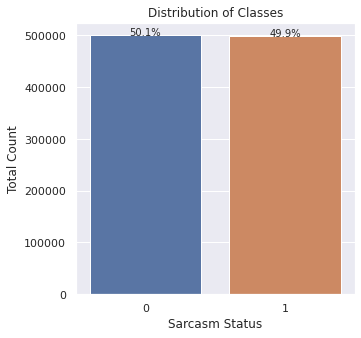

In [ ]:
#visualization of the balance of the labels
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

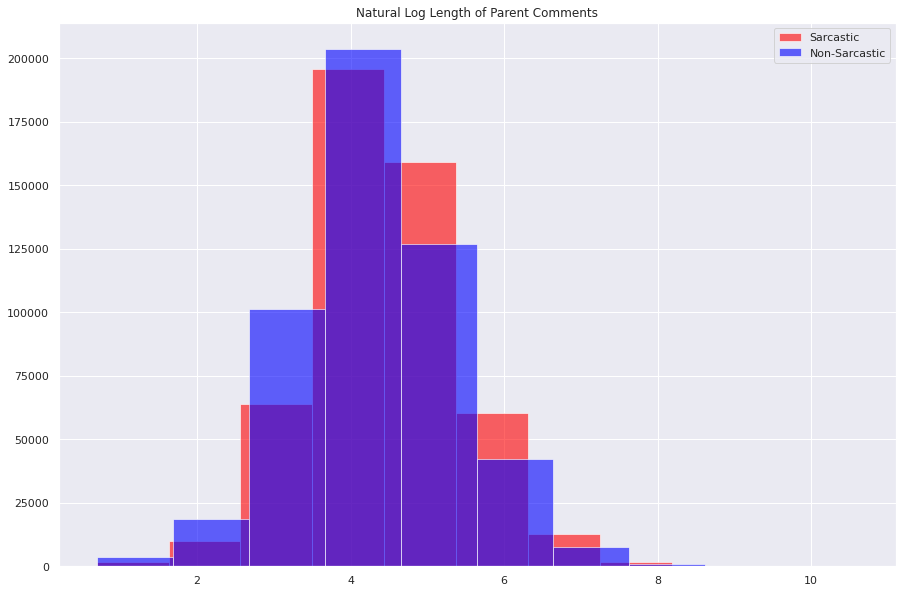

In [ ]:
df['log_comment'] = df['parent_comment'].apply(lambda text: np.log1p(len(text)))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'red')
df[df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'blue')
plt.legend()
plt.title('Natural Log Length of Parent Comments')
plt.show()

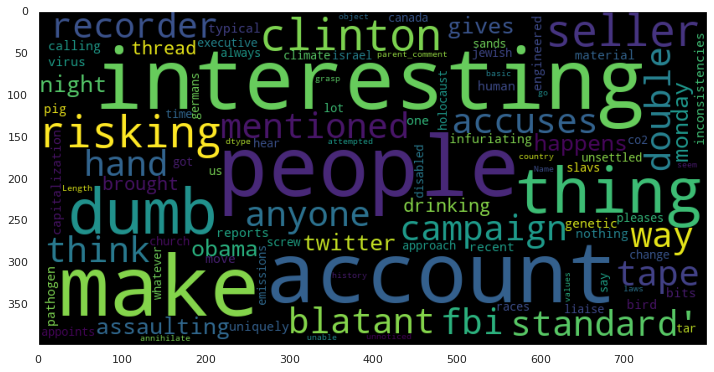

In [ ]:
#wordcloud of parent sarcastic comments
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'parent_comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

In [ ]:
## Subreddits analysis
sub_df = df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3356,0.680870,2285
ShitRedditSays,1284,0.661994,850
worldnews,26377,0.642529,16948
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [ ]:
# Getting the top 10 popular subreddits
df['subreddit'].value_counts()[:10]

AskReddit          65677
politics           39496
worldnews          26377
leagueoflegends    21037
pcmasterrace       18988
funny              17939
news               16891
pics               16154
todayilearned      14161
nfl                14150
Name: subreddit, dtype: int64

In [ ]:
top_categories =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace', 'funny', 'news', 'pics', 'todayilearned', 'nfl']

In [ ]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_categories
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [ ]:
# Calculating the count of Sarcastic and Natural comments for the top 10 subreddits 
for i in range(len(top_categories)):
    temp = df.loc[df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
subreddit

,subreddit,sarcastic,natural,total
0,AskReddit,26367.0,39310.0,65677.0
1,politics,23910.0,15586.0,39496.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8228.0,18988.0
5,funny,8099.0,9840.0,17939.0
6,news,10193.0,6698.0,16891.0
7,pics,7825.0,8329.0,16154.0
8,todayilearned,7754.0,6407.0,14161.0
9,nfl,7215.0,6935.0,14150.0


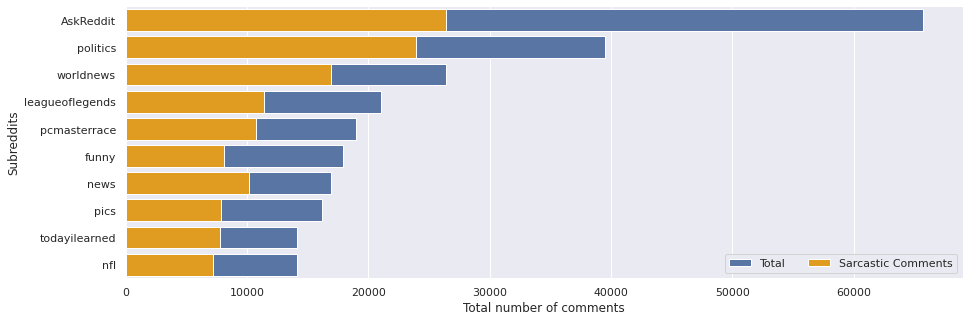

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="orange")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

In [ ]:
#parent_comment vectorization 
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, min_df=2, stop_words="english")
vectorized_comments = vectorizer.fit_transform(df['parent_comment'])
vectorized_comments.shape

(997883, 1000)

In [ ]:
#fitting a model using only vectorized_comments 
X = vectorized_comments
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)
print(X_train.shape, y_train.shape)

(598729, 1000) (598729,)


In [ ]:
#LOGISTIC REGRESSION
#implementation of logistic regression
logit = LogisticRegression(C = 0.1, solver = 'liblinear', max_iter = 1000, verbose = 2, random_state= 42) 

In [ ]:
scores = cross_val_score(logit, X_train, y_train, cv=5, n_jobs = 4)
scores

array([0.55854058, 0.56178077, 0.55734638, 0.55866584, 0.56036578])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.56


In [ ]:
#RANDOM FOREST
#random forest implementation
rfclassifier = RandomForestClassifier(n_estimators=500, bootstrap = True, max_samples = 10000, max_depth = 100, min_samples_split = 2, max_features = 'log2')


In [ ]:
scores = cross_val_score(rfclassifier, X_train, y_train, cv=5, n_jobs = 4)
scores

array([0.55692048, 0.55977653, 0.55591836, 0.55823159, 0.55756817])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.56


In [ ]:
#SVM implementation
clf = LinearSVC(penalty='l2',dual=False,class_weight='balanced',max_iter=10000)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs = 4)
scores

array([0.55909174, 0.56142168, 0.55702904, 0.55873265, 0.55988977])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.56


In [ ]:
#MODEL IMPROVEMENT BY ADDING SUBREDDITS
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df[['parent_comment','subreddit']],y,test_size=0.4)
print(X_train.shape, y_train.shape)



(598729, 2) (598729,)


In [ ]:
tfidf_comments = TfidfVectorizer(ngram_range=(1, 3), stop_words= 'english', max_features=1000, min_df=2)
tfidf_categories = TfidfVectorizer(ngram_range=(0, 2), stop_words = 'english', max_features = 1000, min_df=2)

In [ ]:
merged_features = FeatureUnion([
                ('tfidf_comments', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['parent_comment'], 
                                                  validate=False)),
                            ('tfidf', 
                              tfidf_comments)])),
     ('tfidf_categories', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['subreddit'], 
                                                  validate=False)),
                            ('tfidf', 
                              tfidf_categories)]))])

In [ ]:
#vectorizing the input to apply the cv score
X = merged_features.fit_transform(X_train)

In [ ]:
#LOGISTIC REGRESSION
#implementation of logistic regression
logit = LogisticRegression(C = 0.1, solver = 'liblinear', max_iter = 1000, verbose = 2, random_state= 42) 

In [ ]:
scores = cross_val_score(logit, X, y_train, cv=5, n_jobs = 4)
scores

array([0.57986071, 0.58130543, 0.58162277, 0.58364371, 0.58206188])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.58


In [ ]:
#RANDOM FOREST
#random forest implementation
rfclassifier = RandomForestClassifier(n_estimators=500, bootstrap = True, max_samples = 10000, max_depth = 100, min_samples_split = 2, max_features = 'log2')

In [ ]:
scores = cross_val_score(rfclassifier, X, y_train, cv=5, n_jobs = 4)
scores

array([0.57225294, 0.5735891 , 0.57301288, 0.57578541, 0.57460437])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.57


In [ ]:
#SVM implementation 
clf = LinearSVC(penalty='l2',dual=False,class_weight='balanced',max_iter=10000)

In [ ]:
scores = cross_val_score(clf, X, y_train, cv=5, n_jobs = 4)
scores

array([0.57989411, 0.58096304, 0.58122192, 0.58374392, 0.58141885])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.58


In [ ]:
#GAUSSIAN NAIVE BAYES
nb = MultinomialNB()

In [ ]:
scores = cross_val_score(nb, X, y_train, cv=5, n_jobs = 4)
scores

array([0.57736375, 0.57700466, 0.57675413, 0.58079602, 0.57927262])

In [ ]:
print("accuracy of %0.2f" % (scores.mean()))

accuracy of 0.58


In [ ]:
####PROBABILITIES PREDICTION

In [ ]:
df.sample(n=10)

,label,subreddit,parent_comment
250237,0,AskReddit,get a cube
230870,0,pcmasterrace,i know i'm in the minority but i'm enjoying my time with this game so far. i won't try to defend all of its problems because they're totally valid issues but i'm having a good time regardless.
374712,0,forwardsfromgrandma,at the souvenir shop.
171564,0,seduction,funnily enough i made out with guys for the first time like a month ago. but i have no idea how google could know that.
44092,1,relationships,"god, your husband is pathetic. you need to tell him that and shut this shit down."
578189,1,videos,participants of the movement for black lives conference harassed northeast ohio media group reporter brandon blackwell for recording their public demonstration.
921981,0,CFB,"my group of friends love to make fun of him haha. and most of them are clemson fans. and i'm glad there is a picture of him on facebook with this girl one of my friends used to date that he is tagged in that i commented on saying how bad his rapping is, it makes me happy."
354558,0,fo4,is there a single good reason why multiplayer is missing?
803939,0,carporn,you can get a honda fit for 15k with everything you mentioned. basically every car on the market is better in those departments than anything from the 70's. i'd say that extra 10k is for the name and only the name
275160,1,india,uttarakhand to spend rs. 25 cr to find the herb that cured lord ram's brother


In [ ]:
sample = {'subreddit': ['videos'], 
        'parent_comment': ['participants of the movement for black lives conference harassed northeast ohio media group reporter brandon blackwell for recording their public demonstration']}
comb = pd.DataFrame(sample)
X_parent = tfidf_comments.transform(comb['parent_comment'])
X_cat = tfidf_categories.transform(comb['subreddit'])
X_p = hstack([X_parent, X_cat])

In [ ]:
##Logistic regression
logit.fit(X, y_train)
logit.predict_proba(X)

[LibLinear]

array([[0.35797065, 0.64202935],
       [0.46342514, 0.53657486],
       [0.45285062, 0.54714938],
       ...,
       [0.41682367, 0.58317633],
       [0.43429172, 0.56570828],
       [0.57254279, 0.42745721]])

In [ ]:
logit.predict_proba(X_p)

array([[0.33624134, 0.66375866]])

In [ ]:
##Random forest classifier
rfclassifier.fit(X, y_train)
rfclassifier.predict_proba(X)

array([[0.44322135, 0.55677865],
       [0.46938244, 0.53061756],
       [0.51165661, 0.48834339],
       ...,
       [0.48424384, 0.51575616],
       [0.50074934, 0.49925066],
       [0.52451329, 0.47548671]])

In [ ]:
rfclassifier.predict_proba(X_p)

array([[0.4055915, 0.5944085]])

In [ ]:
##Naive Bayes
nb.fit(X, y_train)
nb.predict_proba(X)

array([[0.3690781 , 0.6309219 ],
       [0.50283535, 0.49716465],
       [0.48985481, 0.51014519],
       ...,
       [0.46307489, 0.53692511],
       [0.45771884, 0.54228116],
       [0.55170789, 0.44829211]])

In [ ]:
nb.predict_proba(X_p)

array([[0.34549882, 0.65450118]])